In [1]:
!pip install pytorch-msssim

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.distributions import Normal
from pytorch_msssim import ssim
import math
import pickle

In [3]:
def get_coord_grid(H, W):
    """
    Returns a tensor of shape (H*W, 2) with normalized (x, y) coordinates
    in the range [-1, 1].
    """
    y = torch.linspace(-1, 1, steps=H)
    x = torch.linspace(-1, 1, steps=W)
    yy, xx = torch.meshgrid(y, x, indexing="ij")
    coords = torch.stack([xx, yy], dim=-1)  # (H, W, 2)
    coords = coords.reshape(-1, 2)          # (H*W, 2)
    return coords

# MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) in [0,1]
])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Define target image
H, W = 28, 28
coords = get_coord_grid(H, W)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.23MB/s]


In [49]:
# --------------------------
# RuleNet
# --------------------------
class RuleNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim

    def forward(self, x, weights):
        """
        coords: (B, N, 2)
        weights: list of [W1, b1, W2, b2, W3, b3]
        """
        W1, b1, W2, b2, W3, b3 = weights

        h1 = torch.bmm(x, W1.transpose(1,2)) + b1
        h1 = torch.sin(h1)

        # Layer 2: (B, N, 16)
        h2 = torch.bmm(h1, W2.transpose(1,2)) + b2
        h2 = torch.sin(h2)

        # Layer 3: (B, N, 1)
        out = torch.bmm(h2, W3.transpose(1,2)) + b3
        out = torch.sigmoid(out)
        return out  # (B, N, 1)


# --------------------------
# HyperNet (AE)
# --------------------------
class HyperNetAE(nn.Module):
    def __init__(self, img_dim=28*28, hidden_dim=256, latent_dim=64, rule_dims=[(8,16),(16,16),(16,1)]):
        super().__init__()
        self.img_dim = img_dim
        self.latent_dim = latent_dim
        self.rule_dims = rule_dims

        # Encoder
        self.C1 = nn.utils.spectral_norm(nn.Conv2d(1, 32, 4, 2, 1))
        self.C2 = nn.utils.spectral_norm(nn.Conv2d(32, 32, 4, 2, 1))
        self.C3 = nn.utils.spectral_norm(nn.Conv2d(32, latent_dim, 4, 2, 1))

        # Decoder (maps z → all RuleNet weights flattened)
        total_weights = sum(in_d*out_d + out_d for in_d, out_d in rule_dims)
        self.dec_fc1 = nn.utils.spectral_norm(nn.Linear(latent_dim, hidden_dim))
        self.dec_fc2 = nn.utils.spectral_norm(nn.Linear(hidden_dim, total_weights))

    def encode(self, x):
        h = F.leaky_relu(self.C1(x))
        h = F.leaky_relu(self.C2(h))
        z = self.C3(h).sum(dim=(2, 3))
        z = z + torch.randn_like(z) * 0.05
        z = F.dropout(z, p=0.1, training=True)
        return z

    def decode(self, z):

        h = torch.relu(self.dec_fc1(z))
        flat_weights = self.dec_fc2(h)

        # Split into RuleNet weight matrices/biases
        weights = []
        idx = 0
        for in_d, out_d in self.rule_dims:
            W_size = in_d * out_d
            b_size = out_d

            W = flat_weights[:, idx:idx+W_size].view(-1, out_d, in_d)
            idx += W_size
            b = flat_weights[:, idx:idx+b_size].view(-1, 1, out_d)
            idx += b_size

            weights.extend([W.squeeze(0), b.squeeze(0)])

        return weights

    def forward(self, imgs):
        """
        imgs: (batch, 1, 28, 28)
        """
        z = self.encode(imgs)
        weights = self.decode(z)
        return weights, z


Epoch: 0/2 Iteration 0 Loss:65.1304


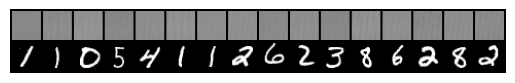

Epoch: 0/2 Iteration 1000 Loss:12.6864


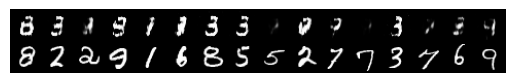

Epoch: 0/2 Iteration 2000 Loss:9.1724


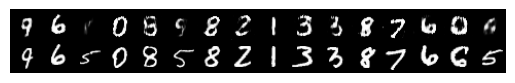

Epoch: 0/2 Iteration 3000 Loss:7.7731


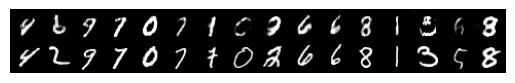

Epoch: 1/2 Iteration 0 Loss:8.1675


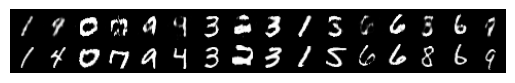

Epoch: 1/2 Iteration 1000 Loss:6.4594


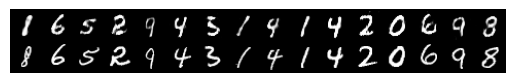

Epoch: 1/2 Iteration 2000 Loss:7.3791


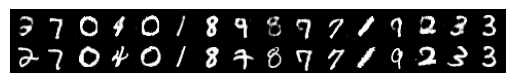

Epoch: 1/2 Iteration 3000 Loss:7.2135


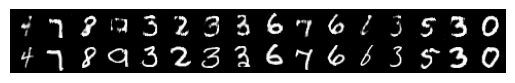

In [51]:
hypernetG = HyperNetAE()
rulenet = RuleNet()

optG = torch.optim.Adam(hypernetG.parameters(), lr=1e-3)
epochs = 2

B = torch.randn(4, 2)
x_proj = 2 * torch.pi * coords @ B.T
x_proj = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


for epoch in range(epochs):
    for k, (imgs, _) in enumerate(train_loader):
        #coords_ = coords.view(1, -1, 2).repeat(imgs.shape[0], 1, 1)
        x_proj_ = x_proj.view(1, 784, 8).repeat(imgs.shape[0], 1, 1)
        #x_proj_ += 0.01*torch.randn_like(x_proj_)

        # HyperNet → weights
        weights, z_enc = hypernetG(imgs)
        # RuleNet forward
        out_flat = rulenet(x_proj_, weights)  # (batch, N, 1)
        out_img = out_flat.view(-1, 1, 28, 28)

        g_loss = 0.01*F.l1_loss(out_img, imgs, reduction="sum") + (1 - ssim(out_img, imgs, data_range=1, size_average=True)) \

        optG.zero_grad()
        g_loss.backward()
        optG.step()


        if k % 1000 == 0:
          print(f"Epoch: {epoch}/{epochs} Iteration {k} Loss:{round(g_loss.item(), 4)}")

          combined = torch.cat([out_img, imgs], dim=0)
          grid = make_grid(combined, nrow=16)
          grid = grid.numpy().transpose(1, 2, 0)
          plt.imshow(grid)
          plt.axis('off')
          plt.show()



In [52]:
latent_vectors = []

with torch.no_grad():
    for imgs, _ in train_loader:
        weights, z_enc = hypernetG(imgs)
        latent_vectors.append(z_enc)

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()

In [68]:
from sklearn.mixture import GaussianMixture

num_components = 12  # usually 10–20 works for MNIST
gmm = GaussianMixture(n_components=num_components, covariance_type='full',
                      max_iter=500)
gmm.fit(latent_vectors)

GaussianMixture(max_iter=500, n_components=15)

tensor(-0.0650)


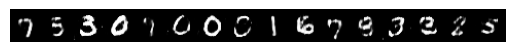

In [78]:
num_samples = 16
z_new, _ = gmm.sample(num_samples)  # shape [num_samples, latent_dim]
z_new = torch.tensor(z_new, dtype=torch.float32)

print(z_new.mean())

with torch.no_grad():
  weights = hypernetG.decode(z_new)
  gen_flat = rulenet(x_proj_, weights)  # (batch, N, 1)
  gen_img = gen_flat.view(-1, 1, 28, 28)

grid = make_grid(gen_img, nrow=16)
grid = grid.numpy().transpose(1, 2, 0)
plt.imshow(grid)
plt.axis('off')
plt.show()